In [1]:
import pandas

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [6]:
class Purchase:
    def __init__(self):
        self.plot_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simsun.ttc', size=10)
        data_path = 'C:\\Users\\user\\anaconda3\\Projects\\BizCases\\data'
        
        item_inventory_file = '%s/模擬庫存.csv' % data_path
        self.item_inventory = pandas.read_csv(item_inventory_file, header=0)
        
        item_order_file = '%s/模擬訂單.csv' % data_path
        self.item_order = pandas.read_csv(item_order_file, header=0)
    def get_orders_by_category(self):
        _subset = self.item_order.groupby(by=['item_category']).count()
        return _subset.rename(columns={'order_id': 'count'})[['count']]

    def get_orders_by_vendor(self):
        _subset = self.item_order.groupby(by=['item_vendor']).count()
        return _subset.rename(columns={'order_id': 'count'})[['count']]
    
    def get_orders_by_item(self):
        _subset = self.item_order[['order_item', 'order_qty']].groupby(by=['order_item']).agg('sum')
        return _subset
    def get_orders_by_item_date(self, order_item):
        _subset = self.item_order.loc[self.item_order['order_item']==order_item].sort_values(by=['delivery_date'])
        _qty = self.item_inventory['qty'].loc[self.item_inventory['product_id']==order_item].values[0]
        
        invenroty_qty = []
        
        for i in range(_subset.shape[0]):
            row = _subset.iloc[i]
            invenroty_qty.append(_qty - row['order_qty'])
            _qty -= row['order_qty']
        
        _subset['stock'] = invenroty_qty
        return _subset
    def get_inventory_item_shortage(self):
        order_items = sorted(self.item_order['order_item'].unique())
        item_shortage = None
        
        for order_item in order_items:
            _subset = self.get_orders_by_item_date(order_item)
            _subset2 = _subset.loc[_subset['stock'] <= 0].copy()
            
            if item_shortage is None:
                item_shortage = _subset2
            else:
                item_shortage = pandas.concat([item_shortage, _subset2])
                
        return item_shortage
    def plot_stock_trend(self, order_item):
        _orders_by_item_date = self.get_orders_by_item_date(order_item)
        _subset = _orders_by_item_date.loc[_orders_by_item_date['order_item'] == order_item].sort_values(by=['delivery_date']).copy()
        _order_dates = _subset['delivery_date']
        _subset = _subset.set_index(_order_dates)

        fig, ax = plt.subplots(dpi=120, figsize=(8, 6))
        _subset['stock'].plot(ax=ax)
        ax.axhline(y=0.0, color='r', linestyle='--')
        
        _positive = _subset.loc[_subset['stock'] >=0 ]
        _negative = _subset.loc[_subset['stock'] < 0 ]
        
        ax.fill_between(_positive.index, 0, _positive['stock'], color='blue')
        ax.fill_between(_negative.index, _negative['stock'], 0, color='red')

        fig.autofmt_xdate()

        ax.set_title('品項: %s' % order_item, fontproperties=self.plot_font)
        ax.set_xlabel('訂單日期', fontproperties=self.plot_font)
        ax.set_ylabel('庫存數', fontproperties=self.plot_font)

        plt.show()

In [7]:
worker = Purchase()

my_orders_by_category = worker.get_orders_by_category()

my_orders_by_vendor = worker.get_orders_by_vendor()

my_orders_by_item = worker.get_orders_by_item()

order_item = 'iNAND 7232'
my_orders_by_item_date = worker.get_orders_by_item_date(order_item)


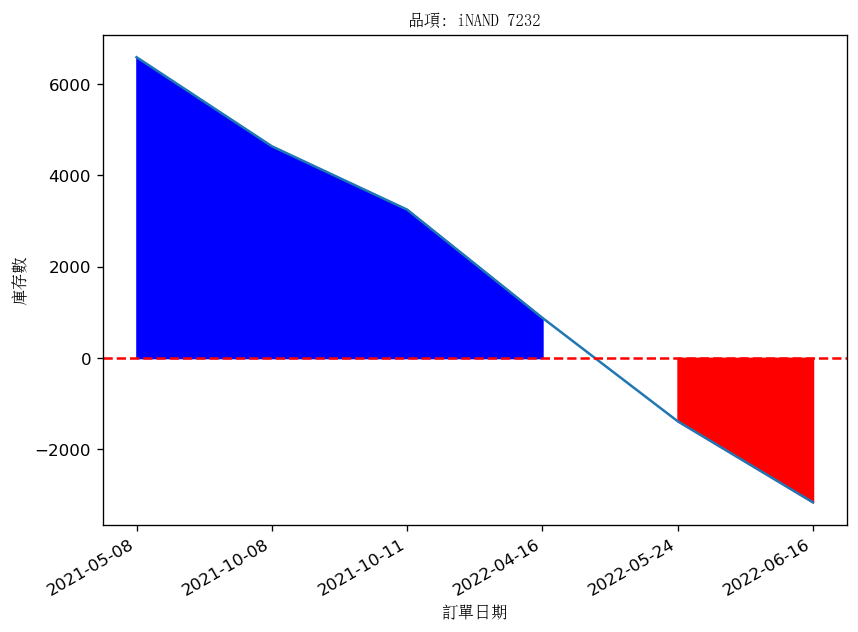

In [8]:
worker.plot_stock_trend(order_item)

In [9]:
my_inventory_item_shortage = worker.get_inventory_item_shortage()

my_inventory_shortage_by_item = my_inventory_item_shortage.groupby('order_item').agg('sum')

my_inventory_item_shortage.to_csv('C:\\Users\\user\\anaconda3\\Projects\\BizCases\\data/模擬訂單庫存餘量.csv', index_label='order_id', index=False)